![](https://www.math.unipd.it/~marcuzzi/BannerStrumentifondamentali.png)


# cuSPARSE

La libreria cuSPARSE è un'implementazione GPU della libreria BLAS specifica per le matrici sparse. Il binding a cuSPARSE di Pyculib fornisce un'interfaccia che permette di lavorare con le matrici sparse di scipy, trasferendole automaticamente (oppure manualmente) sulla memoria device.

Tutte le funzioni sono accessibili tramite gli oggetti della classe `class pyculib.sparse.Sparse`.
    
Vediamo come trasferire in memoria GPU una matrice sparsa!

In [1]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as sla
from scipy.io import mmread
import matplotlib.pyplot as plt

In [2]:
import pyculib
import pyculib.sparse as sparse

In [3]:
# creo oggetto sparse
cusparseH = sparse.Sparse()

Cusparse supporta i seguenti formati compressi per le matrici sparse: 
- BSR Block Sparse Row (non abbiamo visto questo formato, utilizzato per matrici sparse che presentano blocchi densi)
- CSR Compressed Sparse Row
- CSC Compressed Sparse Column

In seguito ci concentreremo sul formato csr, in quanto è il più generico ed è largamente utilizzato.

In [4]:
# carico matrice test
cartella = './matrici_test/'
A = mmread(cartella+'can_292.mtx').tocsr()

In [5]:
# creiamo un'istanza vuota della classe csr_matrix su device
d_A = sparse.CudaSparseMatrix()
# trasferimento host -> device
d_A.from_host_matrix(A)

In [6]:
del d_A
# oppure, analogamente, inizializziamo la matrice in fase di creazione
d_A = sparse.csr_matrix((A.data, A.indices, A.indptr))

In [7]:
# le matrici device formato CSR mantengono i principali metodi della classe csr_matrix di scipy.sparse
d_A.data, d_A.indptr, d_A.indices, d_A.nnz, d_A.shape

(<numba.cuda.cudadrv.devicearray.DeviceNDArray at 0x7f74d017f5f8>,
 2540,
 (292, 292))

In [8]:
dir(d_A)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'copy_to_host',
 'data',
 'dtype',
 'from_attributes',
 'from_host_matrix',
 'host_constructor',
 'indices',
 'indptr',
 'ndim',
 'nnz',
 'shape']

È spesso necessario fornire insieme alle matrici dei descrittori, che contengono informazioni sulle loro proprietà.
Un descrittore si ottiene con la chiamata

`pyculib.sparse.Sparse.matdescr(indexbase, diagtype, fillmode, matrixtype)`

dove

- indexbase = 0,1. Opzionale, se non è specificato viene utilizzato il valore di default specificato nel costruttore pyculib.sparse.Sparse. 0 per indicizzazione che parte da 0, 1 per indicizzazione che parte da 1.
- diagtype = 'N','U'. Opzionale, valore di default ‘N’. ‘N’ significa che la matriche ha elementi diversi dall'unità sulla diagonale. ‘U’ significa che la diagonale contiene solo uno.
- fillmode = 'L', 'U'. Opzionale, valore di default ‘L’. ‘L’ indica che è salvata la parte triangolare inferiore. ‘U’ indica che è salvata la parte trangolare superiore.
- matrixtype = 'G', 'S', 'H', 'T'. Opzionale, valore di default ‘G’. ‘S’ indica che la matrice è simmetrica. ‘H’ indica che la matrice è Hermitiana. ‘T’ indica che la matrice è triangolare. ‘G’ è utilizzato per una matrice generica, che non è ne simmetrica, ne Hermitiana, ne triangolare.

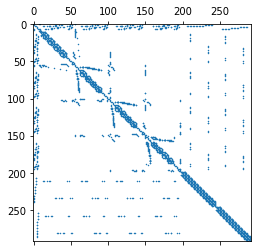

In [9]:
plt.spy(A, markersize = 0.5)

In [10]:
# descrittore per una matrice simmetrica
descrA = cusparseH.matdescr(matrixtype = 'S') #diagtype = 'N', fillmode = 'L', indexbase = 0

# Blas level 1: operazioni vettore sparso-vettore denso

In [11]:
m,n = A.shape

In [12]:
# vettore sparso
xVal = A.data[A.indptr[150]:A.indptr[151]].copy()
xInd = A.indices[A.indptr[150]:A.indptr[151]].copy()
print(xVal)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
# vettore in formato denso
x = np.zeros(n)
x[xInd] = xVal

In [14]:
y = np.ones(n)

In [15]:
# axpyi(alpha, xVal, xInd, y)
# calcolo sul posto di  y = alpha * x + y 
alpha = 1.0
cusparseH.axpyi(alpha, xVal, xInd, y)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [16]:
# Equivalente a 
y = np.ones(n)
y = alpha*x+y

In [17]:
# Verifica
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [18]:
#prodotto interno 
y = np.ones(n)
print('cublas: ', cusparseH.doti(xVal, xInd, y), ' numpy: ', np.dot(x,y))

cublas:  12.0  numpy:  12.0


In [19]:
# gthr(y, xVal, xInd)
# operazione gather: copia gli elementi di y di indice xInd nell'array xVal
print('Prima del gather: xVal = ', xVal)
y = np.arange(n, dtype = xVal.dtype)
cusparseH.gthr(y, xVal, xInd)
print('Dopo il gather: xVal = ', xVal, '\ny[xInd] = ', y[xInd])

Prima del gather: xVal =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Dopo il gather: xVal =  [ 56.  63.  67.  68.  93. 101. 110. 114. 115. 140. 150. 153.] 
y[xInd] =  [ 56.  63.  67.  68.  93. 101. 110. 114. 115. 140. 150. 153.]


In [20]:
# sctr(xVal, xInd, y)
# operazione scatter: copia gli elementi di xVal negli elementi di y di indice xInd
y = np.ones(n)
print('Prima dello scatter: y[xInd] =', y[xInd])
cusparseH.sctr(xVal, xInd, y)
print('Dopo lo scatter: y[xInd] =', y[xInd])

Prima dello scatter: y[xInd] = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Dopo lo scatter: y[xInd] = [ 56.  63.  67.  68.  93. 101. 110. 114. 115. 140. 150. 153.]


In [21]:
del x,y,xVal,xInd

# Blas level 2: operazioni matrice sparsa-vettore

La maggior parte dei metodi della classe `pyculib.sparse.Sparse` accetta le strutture dati singole che compongono una matrice sparsa in formato compresso, i vettori `data`, `indices` e `indptr` nel caso del formato CSR.

Come per cublas, nelle routine di livello 2 e 3 è necessario specificare quale tipo di operazione si deve effettuare sulla matrice con l'argomento 

- trans
    - `trans = 'N'` corrisponde a op($X$) = $X$
    - `trans = 'T'` corrisponde a op($X$) = $X^T$ (trasposta)
    - `trans = 'H'` corrisponde a op($X$) = $X^H$ (trasposta coniugata)

In [22]:
#generazione dei dati
nnz = A.nnz
m,n = A.shape
x = np.ones(n)
y = np.zeros_like(x)

In [23]:
# csrmv(trans, m, n, nnz, alpha, descr, csrVal, csrRowPtr, csrColInd, x, beta, y)
# moltiplicazione matrice (in formato csr) - vettore y = alpha * op(A) * x + beta * y
# trans determina op(A), dim(A) = (m,n), la matrice A ha nnz elementi non nulli e descr e' un opportuno descrittore
alpha = 1.0
beta  = 0.0
cusparseH.csrmv('N', m, n, A.nnz, alpha, descrA, A.data, A.indptr, A.indices, x, beta, y)

In [24]:
#verifica
print('||Ax - y|| = ', np.linalg.norm(A*x - y))

||Ax - y|| =  0.0


### Risoluzione di sistemi triangolari sparsi

In generale, la risoluzione di sistemi triangolari è un'operazione puramente seriale, tuttavia, quando la matrice è sparsa, è possibile ottenere un certo grado di parallelismo che dipende della matrice. Perciò, la risoluzione di questi sistemi di articola in due step: 
- la fase di analisi, che calcola il grado di parallelismo corrispondente pattern della matrice 
- la fase di risolizione del sistema lineare

In [25]:
# creazione del descrittore per matrici triangolari inferiori
descrL = cusparseH.matdescr(matrixtype = 'T', fillmode = 'L')

In [26]:
# creazione matrice triangolare
L = scipy.sparse.tril(A).tocsr()

In [27]:
# csrsv_analysis(trans, m, nnz, descr, csrVal, csrRowPtr, csrColInd)
# fase di analisi del sistema triangolare op(A) * y = alpha * x
# trans determina op(A), m e nnz sono il numero di righe e di non zeri di A risp., 
# descr e' un opportuno descrittore
info = cusparseH.csrsv_analysis('N', m, L.nnz, descrL, L.data, L.indptr, L.indices)

In [28]:
# csrsv_solve(trans, m, alpha, descr, csrVal, csrRowPtr, csrColInd, info, x, y)
# fase di risoluzione del sistema triangolare op(A) * y = alpha * x
# trans determina op(A), m e nnz sono il numero di righe e di non zeri di A risp., 
# descr e' un opportuno descrittore
cusparseH.csrsv_solve('N', m, alpha, descrL, L.data, L.indptr, L.indices, info, x, y) 

In [29]:
#verifica
print(np.linalg.norm(L*y - x))

0.0


In [30]:
del x,y

# Blas level 3: operazioni matrice sparsa-matrice densa

In [31]:
m,k = A.shape
n = 128

In [32]:
# carico matrice test
B = np.asfortranarray(np.random.random((k,n)).astype(A.dtype))

In [33]:
C = np.empty((m,n), order = 'F', dtype = A.dtype)

In [34]:
# csrmm(transA, m, n, k, nnz, alpha, descrA, csrValA, csrRowPtrA, csrColIndA, B, ldb, beta, C, ldc)
# moltiplicazione tra matrici C = alpha * op(A) * B + beta * C
# A e' una matrice sparsa in formato CSR e B e C sono matrici dense
# trans determina op(A), descr e' un opportuno descrittore, dim(A) = (m,k), dim(B) = (k,n), dim(C) = (m,n)
cusparseH.csrmm('N', m, n, k, A.nnz, alpha, descrA, A.data, A.indptr, A.indices, B, k, beta, C, m)

In [35]:
# verifica
print('||C - AB|| = ', np.linalg.norm(C - alpha*A*B))

||C - AB|| =  1.5247222757167875e-13


In [36]:
del B, C

### Risoluzione di un sistema triangolare sparso con membro destro multiplo

In [37]:
X = np.asfortranarray(np.random.random((k,n)).astype(A.dtype))
Y = np.empty((m,n), order = 'F', dtype = A.dtype)

In [38]:
# csrsm_analysis(transA, m, nnz, descrA, csrValA, csrRowPtrA, csrColIndA)
# fase di analisi del sistema triangolare a membro dx multiplo op(A) * Y = alpha * X
# transA determina op(A), m e nnz sono il numero di righe e di non zeri di A risp., descrA e' un opportuno descrittore
info = cusparseH.csrsm_analysis('N', m, L.nnz, descrL, L.data, L.indptr, L.indices)

In [39]:
# csrsm_solve(transA, m, n, alpha, descrA, csrValA, csrRowPtrA, csrColIndA, info, X, ldx, Y, ldy)
# fase di risoluzione del sistema triangolare a membro dx multiplo op(A) * Y = alpha * X
# transA determina op(A), dim(A) = (m,n), descrA e' un opportuno descrittore
# dim(X) = (ldx, n), dim(Y) = (ldy,n) 
cusparseH.csrsm_solve('N', m, k, alpha, descrL, L.data, L.indptr, L.indices, info, X, k, Y, m)

In [40]:
# verifica
print('||L*Y - X|| = ', np.linalg.norm(L*Y - alpha*X))

||L*Y - X|| =  3.086068101611013e-12


In [41]:
del X,Y,L

# Funzioni extra: operazioni matrice sparsa-matrice sparsa

Attenzione: per il momento queste funzioni supportano solo matrici con descrittore di tipo generale: `matrixtype = 'G'`.


In [42]:
m,n = A.shape
B = mmread(cartella+'ash292.mtx').tocsr()

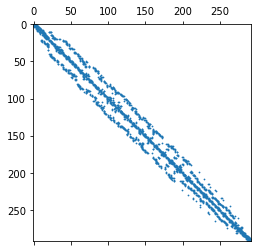

In [43]:
# caricamento funzione test
plt.spy(B, markersize = 0.7)

In [44]:
descrA = cusparseH.matdescr(matrixtype = 'G')
descrB = cusparseH.matdescr(matrixtype = 'G')
descrC = cusparseH.matdescr(matrixtype = 'G')

### Somma di matrici sparse

In [45]:
# XcsrgeamNnz(m, n, descrA, nnzA, csrRowPtrA, csrColIndA, descrB, nnzB, csrRowPtrB, csrColIndB, descrC, csrRowPtrC)
# calcola il  numero di elementi non nulli nella matrice C definita come
# C = alpha * A + beta * B dove A, B, e C sono matrici sparse in formato CSR
# dim(A) = dim(B) = dim(C) = (m,n), descrA e descrB sono opportuni descrittori di A e B,
# indptr e' vettore di lunghezza m+1 che viene sovrascritto con i puntatori alle righe di C

indptr = np.zeros_like(B.indptr)

nnzC = cusparseH.XcsrgeamNnz(m, n, descrA, A.nnz, A.indptr, A.indices,
                              descrB, B.nnz, B.indptr, B.indices, descrC, indptr)

In [46]:
# noto nnzC, e' possibile allocare i vettori di lunghezza nnzC indices e data 
# che compongono insieme a indptr la struttura di C
data    = np.zeros((nnzC,), dtype = A.dtype)
indices = np.zeros((nnzC,), dtype = indptr.dtype)

C = csr_matrix((data,indices,indptr), shape = (m,k))

In [47]:
# csrgeam(m, n, alpha, descrA, nnzA, csrValA, csrRowPtrA, csrColIndA, beta, 
#         descrB, nnzB, csrValB, csrRowPtrB, csrColIndB, 
#         descrC, csrValC, csrRowPtrC, csrColIndC)
# calcola la somma di matrici C = alpha * A + beta * B dove A, B, e C sono matrici sparse in formato CSR
# dim(A) = dim(B) = dim(C) = (m,n), descrA, descrC descrB sono opportuni descrittori di A, B, C
cusparseH.csrgeam(m, n, alpha, descrA, A.nnz, A.data, A.indptr, A.indices, 
                  alpha, descrB, B.nnz, B.data, B.indptr, B.indices,
                  descrC,  C.data, C.indptr, C.indices)

In [48]:
print('||A+B-C|| = ', sla.norm(A+B-C))

||A+B-C|| =  0.0


In [49]:
del indptr, C

### Moltiplicazione tra matrici sparse

In [50]:
m,k = A.shape
k,n = B.shape

indptr = np.zeros_like(A.indptr)

In [51]:
# XcsrgemmNnz(transA, transB, m, n, k, descrA, nnzA, csrRowPtrA, csrColIndA, 
#             descrB, nnzB, csrRowPtrB, csrColIndB, descrC, csrRowPtrC)
# calcola il  numero di elementi non nulli nella matrice C definita come
# C = op(A) * op(B) dove A, B, e C sono matrici sparse in formato CSR
# dim(A) = (m,k), dim(B) = (k,n), dim(C) = (m,n)
# transA e transB determinano op(A) e op(B)
# descrA e descrB sono opportuni descrittori di A e B
# indptr e' vettore di lunghezza m+1 che viene sovrascritto con i puntatori alle righe di C
nnzC = cusparseH.XcsrgemmNnz('N', 'N', m, n, k, descrA, A.nnz, A.indptr, A.indices,
                             descrB, B.nnz, B.indptr, B.indices, descrC, indptr)


In [52]:
# noto nnzC, e' possibile allocare i vettori di lunghezza nnzC indices e data 
# che compongono insieme a indptr la struttura di C
data    = np.zeros((nnzC,), dtype = A.dtype)
indices = np.zeros((nnzC,), dtype = indptr.dtype)

C = csr_matrix((data,indices,indptr), shape = (m,n))

In [53]:
# csrgemm(transA, transB, m, n, k, descrA, nnzA, csrValA, csrRowPtrA, csrColIndA, 
#         descrB, nnzB, csrValB, csrRowPtrB, csrColIndB, 
#         descrC, csrValC, csrRowPtrC, csrColIndC)
# calcola la moltiplicazione matrice-matrice C = op(A) * op(B) dove A, B, e C sono matrici sparse in formato CSR
# dim(A) = (m,k), dim(B) = (k,n), dim(C) = (m,n)
# transA e transB determinano op(A) e op(B)
# descrA, descrB e descrC sono opportuni descrittori di A, B, e C
cusparseH.csrgemm('N', 'N', m, n, k, descrA, A.nnz, A.data, A.indptr, A.indices,
                  descrB, B.nnz, B.data, B.indptr, B.indices, 
                  descrC, C.data, C.indptr, C.indices)

In [54]:
print('||A*B-C|| = ', sla.norm(A*B-C))

||A*B-C|| =  0.0


In [55]:
del A,B,C